In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, TruncatedSVD

from dataclasses import dataclass
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union, Optional
import pyodbc

import math
import re
import warnings

print("hello world")

hello world


In [21]:
# read xlsx into pandas
df = pd.read_excel("../isec_data/df_sample_100k.xlsx", engine="openpyxl", index_col=0)
df.iloc[:10]

,serial_no,acct_opn_dt,name,dob,age,gender,marital_status,email,city,state,...,iai_uccstatus_dt,iai_class_download_run_no,iai_modify_dt_run_no,iai_enable_for_dwid,iai_bnk_account_flag,iai_comm_class_status,iai_bank_type,iai_ifsc_cd,iai_bnk_account_flag_changed_dt,match_id
0,9007305054,2017-08-19,SHARAD SINGH,1995-02-02,31,M,Y,95ssharda@gmail.com,RAE BARELI,UTTAR PRADESH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504297e+09
1,9007305091,2017-08-18,HIRDESH SINGH,1944-02-10,82,F,M,singhvikekkumar@gmail.com,EAST DELHI,DELHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504296e+09
2,9007305145,2017-10-07,NIRANJAN KUMAR,1990-02-15,36,M,N,niranjankumar.singh2@gmail.com,DELHI,DELHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504359e+09
3,9007305200,2017-07-18,ABHISHEK SHARMA,1997-09-20,28,M,Y,abhishekkharma1997@gmail.com,FARIDABAD,HARYANA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504258e+09
4,9007305236,2017-08-09,ASHOK KUMAR LAVANIA,1946-12-27,79,M,Y,alavania27@gmail.com,DELHI,DELHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504289e+09
5,9007305538,2017-06-02,SURUCHI GUPTA,1988-02-23,38,F,Y,suruchibansal2388@gmail.com,NOIDA,UTTAR PRADESH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504207e+09
6,9007305651,2017-06-27,SHORBAN BANERJEE,1971-12-28,54,F,Y,shorban.banerjee@gmail.com,NOIDA,UTTAR PRADESH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504231e+09
7,9007305877,2017-08-01,SANJEEV GHOSH,1970-03-24,56,M,Y,sanjeev@whitehouseoverseas.com,DELHI,DELHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504274e+09
8,9007306867,2017-10-05,NIDHI BEMBI,1994-09-14,31,F,N,bembindhi@gmail.com,LUDHIANA,PUNJAB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504355e+09
9,9007307094,2017-07-25,RUCHI PUNEET GUPTA,1986-06-01,40,F,Y,ruchi.skyblue@gmail.com,DHULE,MAHARASHTRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504266e+09


In [22]:
# transform income
df["income"] = df["income_desc"].apply(
    lambda v: (
        int(int(m.group(1)) + int(m.group(2)) / 2)
        if pd.notna(v) and (m := re.search(r"(\d+)\s*LAC\s*TO\s*(\d+)\s*LAC", v, re.I))
        else None
    )
)

# convert datetimes
df_clean = df.loc[:, ~df.columns.to_series().map(lambda c: pd.api.types.is_datetime64_any_dtype(df[c]))].copy()
# drop any columns with all nulls
df_clean = df_clean.dropna(axis=1, how='all')
# drop PII etc.
df_clean = df_clean.drop(columns=["serial_no", "name", "email", "city", "state", "country", "pincode", "income_desc", "sourcing_team", "sourcing_channel", "iaf_publisher", "advisory_team", "dnd_flag", "dnc_flag", "neq_total_assets_million", "peak_asset_val_million", "vertical", "mobile_number", "pan", "bsp_flag", "bank_flag", "ers_mapped"], errors="coerce")

df_clean[:10]

,age,gender,marital_status,education_desc,occupation_desc,ri_flag,nri_flag,mf_vertical,eq_vertical,no_of_logins,...,brokerage_type,grade,scheme_code,brokerage_rate,brkg_type,mtf_brkg,income_segment,pincode_affluence,match_id,income
0,31,M,Y,GRADUATE,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,28.0,...,MSAVER,D,Special,29.0,High,High,PB,Low,8.504297e+09,3.0
1,82,F,M,OTHERS,HOUSEWIFE,Y,N,VIRTUAL RM,SELECT,1711.0,...,FPRMN1001,A,Special,10.0,Low,Low,WM,Very High,8.504296e+09,3.0
2,36,M,N,OTHERS,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,765.0,...,EMP07007N,B,Special,NaN,NaN,NaN,PB,Very High,8.504359e+09,10.0
3,28,M,Y,OTHERS,PROFESSIONAL,Y,N,ONLINE,ONLINE,45.0,...,MSAVER,B,Special,29.0,High,High,WM,Very High,8.504258e+09,3.0
4,79,M,Y,GRADUATE,PRIVATE SECTOR,Y,N,PWM-PHYSICAL,WEALTH,742.0,...,APRM07007,A,Special,7.0,Low,Low,GPC,Very High,8.504289e+09,17.0
5,38,F,Y,GRADUATE,HOUSEWIFE,Y,N,ONLINE,ONLINE,217.0,...,PPSN15015,A,Special,15.0,Low,Low,PB,Very High,8.504207e+09,3.0
6,54,F,Y,GRADUATE,SELFEMPLOYED,Y,N,VIRTUAL RM,SELECT,567.0,...,MSAVER,B,Special,29.0,High,High,WM,Very High,8.504231e+09,10.0
7,56,M,Y,GRADUATE,SELFEMPLOYED,Y,N,VIRTUAL RM,ONLINE,395.0,...,PRM05005,A,Special,NaN,NaN,NaN,WM,Very High,8.504274e+09,50.0
8,31,F,N,GRADUATE,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,2722.0,...,EMS07007N,B,Special,NaN,NaN,NaN,PB,Very High,8.504355e+09,17.0
9,40,F,Y,OTHERS,HOUSEWIFE,Y,N,ONLINE,ONLINE,283.0,...,APRN25025,A,Special,25.0,High,High,PB,Very High,8.504266e+09,3.0


In [23]:
txns = pd.read_excel("../isec_data/df_txns_equity_sample_100k.xlsx", engine="openpyxl", index_col=0)
txns.iloc[:10]

,trd_trd_ref,trd_clm_mtch_accnt,trd_xchng_cd,trd_stck_cd,trd_xchng_sgmnt_cd,trd_xchng_sgmnt_sttlmnt,trd_ordr_rfrnc,trd_trd_dttm,trd_trnsctn_typ,trd_trd_flw,...,trd_brkrg_typ,trd_cgst_amt,trd_sgst_amt,trd_ugst_amt,trd_igst_amt,trd_atm_upfront_amt,trd_fixed_brkg,trd_variable_brkg,trd_brkrg_mdl,trd_trd_dt
0,2005/0324/41160834,6500001632,NSE,ORAFIN,N,2005057,20050324N200008143,2005-03-24 10:51:00,BFP,B,...,NaN,0.8167,0.8167,0.0,0.0,NaN,NaN,NaN,NaN,2005-03-24
1,2025/1208/83387995,8506005900,NSE,BEML,M,2025234,20251209Z000025263,2025-12-09 10:58:00,BFM,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-12-09
2,2009/0813/15145544,8500625493,NSE,TECMAH,N,2009150,20090813N500018758,2009-08-13 15:19:00,FBT,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-08-13
3,2009/0316/73146028,8500919526,NSE,CHEPET,N,2009048,20090316N300001585,2009-03-16 10:02:00,CSM,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-03-16
4,2005/0112/35994467,8500433501,NSE,ALLBAN,N,2005008,20050112N300014306,2005-01-12 11:50:00,CBM,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-01-12
5,2012/0410/69130228,8502177098,NSE,AXIBAN,N,2012067,20120410N100016298,2012-04-10 11:47:00,TSF,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-04-10
6,2007/1031/64321185,8500073488,NSE,RILPET,N,2007208,20071031N100023049,2007-10-31 13:58:00,TSC,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-10-31
7,2009/0401/77049558,8500248468,NSE,ICIBAN,N,2009060,20090401N600007372,2009-04-01 11:42:00,TSC,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-04-01
8,2014/0514/12536091,8500609817,NSE,TRAREC,N,2014089,20140514N300018359,2014-05-14 10:08:00,SFP,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-05-14
9,2013/1205/79862858,8502240795,NSE,YESBAN,N,2013232,20131205N500017765,2013-12-05 15:06:00,TSC,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-05


In [24]:
# join df to txns based on match_id and trd_clm_mtch_accnt
df_merged = df_clean.merge(txns, left_on="match_id", right_on="trd_clm_mtch_accnt", how="left", suffixes=("", "_eq"))
df_merged["trd_stck_cd"].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
num = df_clean.select_dtypes(include=['number']).columns
cat = df_clean.select_dtypes(include=['object', 'category', 'bool']).columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat)
])
kmeans = KMeans(n_clusters=5, n_init="auto", random_state=20, verbose=1)
kmeans

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",5
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",1
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",20
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [26]:
print([x for x in num.append(cat)])

['age', 'no_of_logins', 'no_logins_last_30', 'no_logins_last_60', 'no_logins_last_90', 'eq_total_assets', 'neq_total_assets', 'peak_asset_val', 'total_products', 'experian_score', 'mtf_rate', 'allocated_amt', 'brokerage_rate', 'match_id', 'income', 'gender', 'marital_status', 'education_desc', 'occupation_desc', 'ri_flag', 'nri_flag', 'mf_vertical', 'eq_vertical', 'acct_status', 'vertical_disg', 'account_type', 'brokerage_type', 'grade', 'scheme_code', 'brkg_type', 'mtf_brkg', 'income_segment', 'pincode_affluence']


In [27]:
X = pre.fit_transform(df_clean)
labels = kmeans.fit_predict(X)

Z = PCA(n_components=3, random_state=20).fit_transform(X.toarray() if hasattr(X, "toarray") else X)
out = df_clean.assign(cluster=labels)
out[:10]

Initialization complete
Iteration 0, inertia 683.4253847281245.
Iteration 1, inertia 493.94721488685616.
Iteration 2, inertia 483.96769760327896.
Converged at iteration 2: strict convergence.


,age,gender,marital_status,education_desc,occupation_desc,ri_flag,nri_flag,mf_vertical,eq_vertical,no_of_logins,...,grade,scheme_code,brokerage_rate,brkg_type,mtf_brkg,income_segment,pincode_affluence,match_id,income,cluster
0,31,M,Y,GRADUATE,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,28.0,...,D,Special,29.0,High,High,PB,Low,8.504297e+09,3.0,1
1,82,F,M,OTHERS,HOUSEWIFE,Y,N,VIRTUAL RM,SELECT,1711.0,...,A,Special,10.0,Low,Low,WM,Very High,8.504296e+09,3.0,1
2,36,M,N,OTHERS,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,765.0,...,B,Special,NaN,NaN,NaN,PB,Very High,8.504359e+09,10.0,1
3,28,M,Y,OTHERS,PROFESSIONAL,Y,N,ONLINE,ONLINE,45.0,...,B,Special,29.0,High,High,WM,Very High,8.504258e+09,3.0,1
4,79,M,Y,GRADUATE,PRIVATE SECTOR,Y,N,PWM-PHYSICAL,WEALTH,742.0,...,A,Special,7.0,Low,Low,GPC,Very High,8.504289e+09,17.0,3
5,38,F,Y,GRADUATE,HOUSEWIFE,Y,N,ONLINE,ONLINE,217.0,...,A,Special,15.0,Low,Low,PB,Very High,8.504207e+09,3.0,1
6,54,F,Y,GRADUATE,SELFEMPLOYED,Y,N,VIRTUAL RM,SELECT,567.0,...,B,Special,29.0,High,High,WM,Very High,8.504231e+09,10.0,1
7,56,M,Y,GRADUATE,SELFEMPLOYED,Y,N,VIRTUAL RM,ONLINE,395.0,...,A,Special,NaN,NaN,NaN,WM,Very High,8.504274e+09,50.0,0
8,31,F,N,GRADUATE,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,2722.0,...,B,Special,NaN,NaN,NaN,PB,Very High,8.504355e+09,17.0,1
9,40,F,Y,OTHERS,HOUSEWIFE,Y,N,ONLINE,ONLINE,283.0,...,A,Special,25.0,High,High,PB,Very High,8.504266e+09,3.0,1


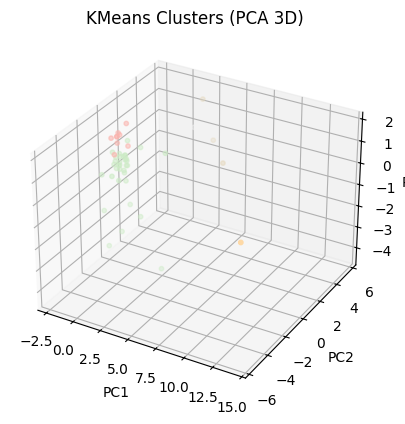

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=labels, s=10, cmap="Pastel1")
plt.title("KMeans Clusters (PCA 3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

In [29]:
import plotly.express as px
import pandas as pd

df_plot = pd.DataFrame({
    "PC1": Z[:, 0],
    "PC2": Z[:, 1],
    "PC3": Z[:, 2],
    "cluster": labels.astype(str)
})

fig = px.scatter_3d(
    df_plot, x="PC1", y="PC2", z="PC3",
    color="cluster",
    opacity=0.8
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title="KMeans Clusters (PCA 3D)")
fig.show()

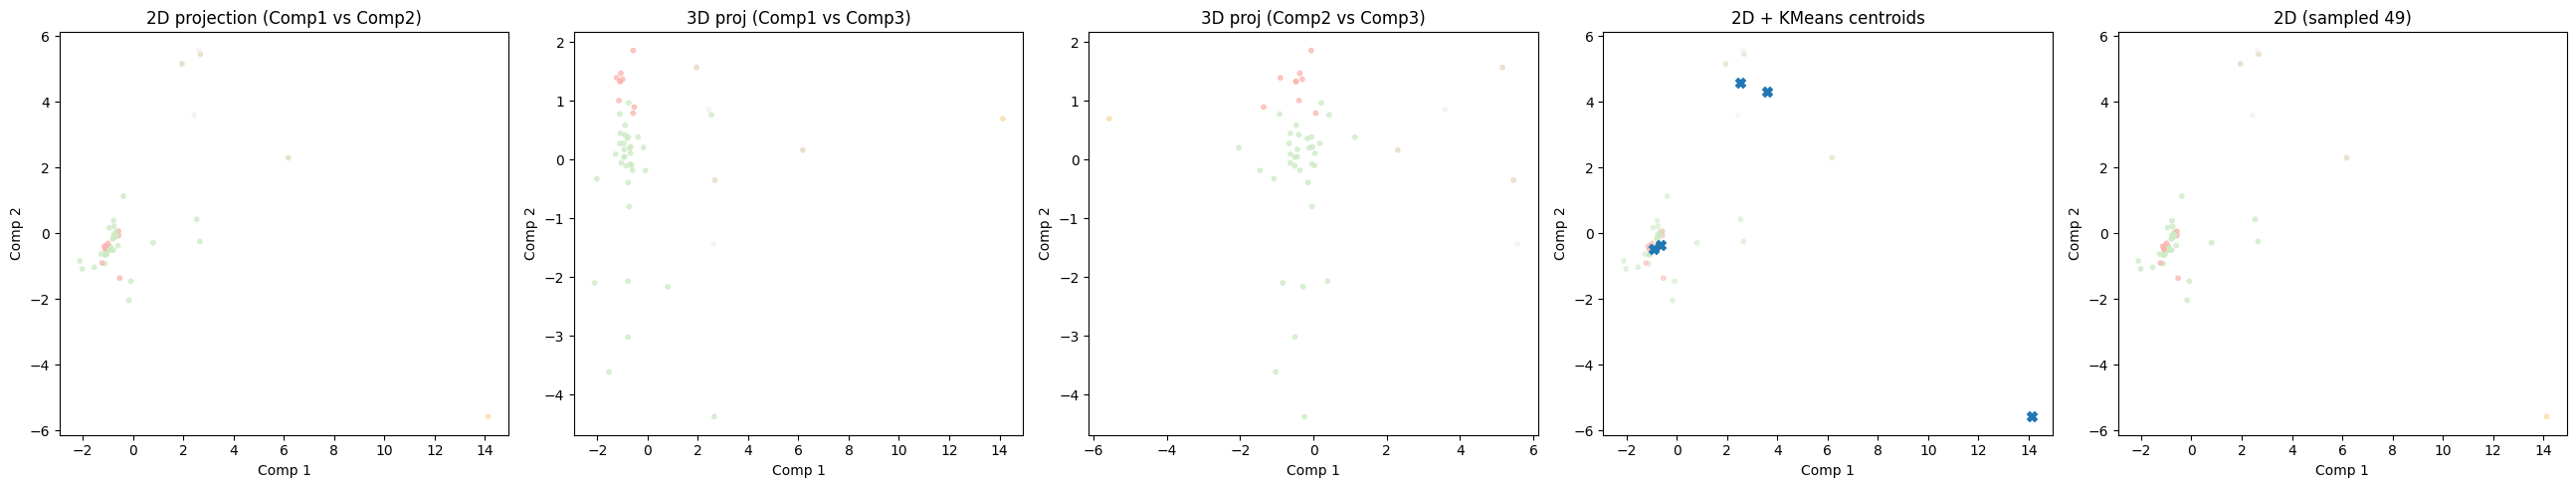

In [30]:
X_for_kmeans = X
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Use PCA if dense; TruncatedSVD if sparse (works like PCA for visualization)
is_sparse = hasattr(X_for_kmeans, "tocsr") or "scipy.sparse" in str(type(X_for_kmeans)).lower()
Reducer = TruncatedSVD if is_sparse else PCA

reducer2 = Reducer(n_components=2, random_state=20)
reducer3 = Reducer(n_components=3, random_state=20)

X2 = reducer2.fit_transform(X_for_kmeans)
X3 = reducer3.fit_transform(X_for_kmeans)

# IMPORTANT: transform centers with the SAME fitted reducer2
C2 = reducer2.transform(centers)

# sample for the 5th plot (keeps it fast)
n = X2.shape[0]
sample_n = min(20000, n)
idx = np.random.default_rng(20).choice(n, size=sample_n, replace=False)

# -----------------------------
# 5 subplots in one row
# -----------------------------
fig, axes = plt.subplots(1, 5, figsize=(26, 5))

def sc(ax, x, y, title):
    ax.scatter(x, y, c=labels, s=10, alpha=0.7, cmap="Pastel1")
    ax.set_title(title)
    ax.set_xlabel("Comp 1")
    ax.set_ylabel("Comp 2")

# 1) 2D (comp1 vs comp2)
sc(axes[0], X2[:, 0], X2[:, 1], "2D projection (Comp1 vs Comp2)")

# 2) 3D projection: comp1 vs comp3
sc(axes[1], X3[:, 0], X3[:, 2], "3D proj (Comp1 vs Comp3)")

# 3) 3D projection: comp2 vs comp3
sc(axes[2], X3[:, 1], X3[:, 2], "3D proj (Comp2 vs Comp3)")

# 4) 2D + centroids
axes[3].scatter(X2[:, 0], X2[:, 1], c=labels, s=10, alpha=0.5, cmap="Pastel1")
axes[3].scatter(C2[:, 0], C2[:, 1], s=50, marker="X")
axes[3].set_title("2D + KMeans centroids")
axes[3].set_xlabel("Comp 1")
axes[3].set_ylabel("Comp 2")

# 5) 2D sampled
axes[4].scatter(X2[idx, 0], X2[idx, 1], c=np.asarray(labels)[idx], s=10, alpha=0.7, cmap="Pastel1")
axes[4].set_title(f"2D (sampled {sample_n:,})")
axes[4].set_xlabel("Comp 1")
axes[4].set_ylabel("Comp 2")

plt.tight_layout()
plt.show()

In [31]:
df_pc = pd.DataFrame(Z, columns=["PC1", "PC2", "PC3"], index=df_clean.loc[:, num.union(cat)].index)
df_tagged = df_clean.loc[:, num.union(cat)].loc[df_clean.loc[:, num.union(cat)].index].join(df_pc).assign(cluster=labels)
df_tagged.sort_values("PC2", ascending=False)[:10]

,account_type,acct_status,age,allocated_amt,brkg_type,brokerage_rate,brokerage_type,education_desc,eq_total_assets,eq_vertical,...,peak_asset_val,pincode_affluence,ri_flag,scheme_code,total_products,vertical_disg,PC1,PC2,PC3,cluster
21,THREE_IN_ONE,A,83,749375.0,Low,7.0,PPSN07007,POST GRADUATE,0.0,WEALTH,...,4.438431e+07,Very High,Y,Special,7.0,PWM-PHYSICAL,2.623289,5.563454,-1.442053,4
4,THREE_IN_ONE,A,79,189.0,Low,7.0,APRM07007,GRADUATE,0.0,WEALTH,...,8.858123e+07,Very High,Y,Special,12.0,PWM-PHYSICAL,2.678990,5.455973,-0.351925,3
17,THREE_IN_ONE,A,70,NaN,High,29.0,MSAVER,POST GRADUATE,0.0,WEALTH,...,1.057839e+08,Very High,Y,Special,5.0,PWM-PHYSICAL,1.949287,5.156365,1.567025,3
15,THREE_IN_ONE,A,74,429887.0,High,29.0,MSAVER,POST GRADUATE,0.0,WEALTH,...,6.096317e+07,Very High,Y,Special,12.0,PWM-PHYSICAL,2.431746,3.590486,0.851681,4
20,THREE_IN_ONE,A,68,NaN,Low,10.0,FPRMN1001,POST GRADUATE,0.0,ONLINE,...,7.182258e+07,Very High,Y,Special,15.0,VIRTUAL RM,6.175650,2.299729,0.160056,3
18,THREE_IN_ONE,A,58,4426.0,High,29.0,MSAVER,POST GRADUATE,0.0,ONLINE,...,1.405889e+07,Very High,Y,Special,6.0,VIRTUAL RM,-0.382966,1.132173,0.380294,1
16,THREE_IN_ONE,A,64,NaN,High,22.0,PRMN22022,POST GRADUATE,0.0,ONLINE,...,5.695794e+06,Very High,Y,Special,13.0,VIRTUAL RM,2.536093,0.427939,0.758772,1
5,THREE_IN_ONE,A,38,NaN,Low,15.0,PPSN15015,GRADUATE,0.0,ONLINE,...,8.427340e+05,Very High,Y,Special,7.0,ONLINE,-0.774630,0.386781,-2.069372,1
19,THREE_IN_ONE,A,51,949.0,High,29.0,MSAVER,GRADUATE,0.0,ONLINE,...,4.733602e+06,Very High,Y,Special,5.0,VIRTUAL RM,-0.749368,0.213523,0.961036,1
6,THREE_IN_ONE,A,54,233.0,High,29.0,MSAVER,GRADUATE,NaN,SELECT,...,5.969920e+06,Very High,Y,Special,8.0,VIRTUAL RM,-0.947513,0.174382,0.273017,1


In [32]:
cluster_summary = df_tagged.groupby("cluster").mean(numeric_only=True)
feature_importance = (cluster_summary.max() - cluster_summary.min()).sort_values(ascending=False)
feature_importance[:10]

peak_asset_val       8.535640e+07
neq_total_assets     6.878808e+07
eq_total_assets      3.392531e+06
match_id             3.151821e+06
allocated_amt        5.896130e+05
no_of_logins         6.972333e+03
no_logins_last_90    3.267333e+02
experian_score       3.219333e+02
no_logins_last_60    1.800000e+02
no_logins_last_30    1.158667e+02
dtype: float64

In [33]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=pre.get_feature_names_out())
centroid_spread = (centroids.max() - centroids.min()).sort_values(ascending=False)
centroid_spread.iloc[:20]

num__eq_total_assets                 7.072541
num__no_logins_last_30               6.397164
num__no_logins_last_90               6.232324
num__no_logins_last_60               6.089691
num__no_of_logins                    6.083044
num__allocated_amt                   4.873975
num__mtf_rate                        4.776394
num__peak_asset_val                  3.770502
num__neq_total_assets                3.641570
num__brokerage_rate                  2.917325
num__income                          2.790861
num__total_products                  2.268676
num__match_id                        2.196042
num__age                             1.672614
cat__education_desc_GRADUATE         1.000000
cat__marital_status_Y                1.000000
cat__marital_status_N                1.000000
cat__education_desc_POST GRADUATE    1.000000
cat__occupation_desc_OTHER           1.000000
cat__occupation_desc_RETIRED         1.000000
dtype: float64

In [34]:
silhouette_score(X, labels)

0.11329933829023935

In [35]:
regressions = []
for feature in num.union(cat):
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    X_feat = df_tagged[[feature]].copy()
    # handle categorical features
    if feature in cat:
        X_feat = pd.get_dummies(X_feat, columns=[feature], drop_first=False)
    # drop rows with NaN
    mask = X_feat.notna().all(axis=1) & df_tagged["PC1"].notna()
    lr.fit(X_feat[mask], df_tagged.loc[mask, "PC1"])
    r2 = lr.score(X_feat[mask], df_tagged.loc[mask, "PC1"])
    regressions.append((feature, r2, lr.coef_))

regressions.sort(key=lambda x: x[1], reverse=True)
for feature, r2, coef in regressions[:10]:
    print(f"Feature: {feature}, R2: {r2:.2f}")

Feature: no_logins_last_30, R2: 0.88
Feature: no_logins_last_60, R2: 0.87
Feature: no_logins_last_90, R2: 0.85
Feature: no_of_logins, R2: 0.79
Feature: brokerage_type, R2: 0.70
Feature: eq_total_assets, R2: 0.67
Feature: vertical_disg, R2: 0.47
Feature: brkg_type, R2: 0.47
Feature: mtf_brkg, R2: 0.47
Feature: mtf_rate, R2: 0.45


In [36]:
# regression of each feature against PC1 sorted by highest correlation

regressions = []
for feature in num.union(cat):
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    X_feat = df_tagged[[feature]].copy()
    # handle categorical features
    if feature in cat:
        X_feat = pd.get_dummies(X_feat, columns=[feature], drop_first=False)
    # drop rows with NaN
    mask = X_feat.notna().all(axis=1) & df_tagged["PC2"].notna()
    lr.fit(X_feat[mask], df_tagged.loc[mask, "PC2"])
    r2 = lr.score(X_feat[mask], df_tagged.loc[mask, "PC2"])
    regressions.append((feature, r2, lr.coef_))

regressions.sort(key=lambda x: x[1], reverse=True)
for feature, r2, coef in regressions[:10]:
    print(f"Feature: {feature}, R2: {r2:.2f}")

Feature: income_segment, R2: 0.69
Feature: peak_asset_val, R2: 0.64
Feature: mtf_rate, R2: 0.58
Feature: brokerage_type, R2: 0.53
Feature: neq_total_assets, R2: 0.49
Feature: allocated_amt, R2: 0.38
Feature: vertical_disg, R2: 0.34
Feature: education_desc, R2: 0.25
Feature: eq_total_assets, R2: 0.25
Feature: age, R2: 0.22


In [37]:
regressions = []
for feature in num.union(cat):
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    X_feat = df_tagged[[feature]].copy()
    # handle categorical features
    if feature in cat:
        X_feat = pd.get_dummies(X_feat, columns=[feature], drop_first=False)
    # drop rows with NaN
    mask = X_feat.notna().all(axis=1) & df_tagged["PC3"].notna()
    lr.fit(X_feat[mask], df_tagged.loc[mask, "PC3"])
    r2 = lr.score(X_feat[mask], df_tagged.loc[mask, "PC3"])
    regressions.append((feature, r2, lr.coef_))

regressions.sort(key=lambda x: x[1], reverse=True)
for feature, r2, coef in regressions[:10]:
    print(f"Feature: {feature}, R2: {r2:.2f}")

Feature: experian_score, R2: 0.66
Feature: occupation_desc, R2: 0.49
Feature: mtf_rate, R2: 0.43
Feature: brokerage_type, R2: 0.36
Feature: income, R2: 0.31
Feature: gender, R2: 0.28
Feature: grade, R2: 0.25
Feature: marital_status, R2: 0.25
Feature: vertical_disg, R2: 0.23
Feature: income_segment, R2: 0.23
